In [1]:
# queste due righe a seguire mi servono per far si che ogni volta che faccio una modifica alle mie def mi si aggiorna in automatico
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import pickle as pkl    
from utils import boxplot, get_data_for_condition, boxplot_2x2
from matplotlib import patches
from pymer4.models import Lmer
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects import Formula
pandas2ri.activate()

In [22]:
# Carico i dati
with open('ResultsFinal.pkl','rb') as f:
    results_df = pkl.load(f)

# Variabili utili per il resto
variables = ['CoinsGainedPerTrial','BoxOpenedFirstArea','BoxOpenedPerTrial','CoinGainedPerBoxPerTrialMean','VisitedAreasEnteredOnce']
variables_time = ['TempiTraCasse','TempiUltimaPrimaNuovaArea']

variables_pretty_names = {'CoinsGainedPerTrial':'Total coins',
                          'BoxOpenedFirstArea':'Boxes collected in first area',
                          'BoxOpenedPerTrial': 'Boxes collected',
                          'CoinGainedPerBoxPerTrialMean': 'Average coins per box',
                          'VisitedAreasEnteredOnce': 'Number of visited areas',
                          'TempiTraCasse': 'Average box collection time',
                          'TempiUltimaPrimaNuovaArea': 'Average room change and first box collection time'
                          }


# Condizioni con cui poi separerò i dati
condition_battery_env = [
    {'LongBattery':True, 'RichEnvironment':True}, 
    {'LongBattery':True, 'RichEnvironment':False},
    {'LongBattery':False, 'RichEnvironment':True}, 
    {'LongBattery':False, 'RichEnvironment':False}
]

condition_battery_firstarea = [
    {'LongBattery':True, 'RichEnvironment':False, 'FirstAreaRich':True},
    {'LongBattery':True, 'RichEnvironment':False, 'FirstAreaRich':False},
    {'LongBattery':False, 'RichEnvironment':False, 'FirstAreaRich':True},
    {'LongBattery':False, 'RichEnvironment':False, 'FirstAreaRich':False},
]


condition_battery_firstarea_rich = [
    {'LongBattery':True, 'RichEnvironment':True, 'FirstAreaRich':True},
    {'LongBattery':True, 'RichEnvironment':False, 'FirstAreaRich':True},
    {'LongBattery':False, 'RichEnvironment':True, 'FirstAreaRich':True},
    {'LongBattery':False, 'RichEnvironment':False, 'FirstAreaRich':True},
]

condition_battery_env_firsthalf = [
    {'LongBattery':True, 'RichEnvironment':True, 'FirstHalf':True}, 
    {'LongBattery':True, 'RichEnvironment':False, 'FirstHalf':True},
    {'LongBattery':False, 'RichEnvironment':True, 'FirstHalf':True}, 
    {'LongBattery':False, 'RichEnvironment':False, 'FirstHalf':True}
]

condition_battery_env_secondhalf = [
    {'LongBattery':True, 'RichEnvironment':True, 'FirstHalf':False}, 
    {'LongBattery':True, 'RichEnvironment':False, 'FirstHalf':False},
    {'LongBattery':False, 'RichEnvironment':True, 'FirstHalf':False}, 
    {'LongBattery':False, 'RichEnvironment':False, 'FirstHalf':False}
]

condition_battery_firstarea_secondhalf = [
    {'LongBattery':True, 'RichEnvironment':False, 'FirstAreaRich':True, 'FirstHalf':False},
    {'LongBattery':True, 'RichEnvironment':False, 'FirstAreaRich':False, 'FirstHalf':False},
    {'LongBattery':False, 'RichEnvironment':False, 'FirstAreaRich':True, 'FirstHalf':False},
    {'LongBattery':False, 'RichEnvironment':False, 'FirstAreaRich':False, 'FirstHalf':False},
]


In [3]:
# Informazioni globali su plot e colori

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Computer Modern Sans Serif",
    "font.serif" : "Bookman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 14,
    "font.size": 14,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
}

plt.rcParams.update(tex_fonts)

color_blue = np.array([66, 119, 157])/255
color_blue_pastel = np.array([108, 149, 178])/255
color_bordeaux = np.array([199, 41, 83])/255
color_yellow = np.array([229, 149, 0])/255
color_red_claret = np.array([132, 0, 50])/255
color_red_crimson = np.array([215, 38, 56])/255
color_pink_coral = np.array([216, 131, 115])/255
color_light_coral = np.array([239, 118, 122])/255
color_violet = np.array([222, 205, 245])/255
color_pink_cherry = np.array([244, 164, 174])/255
color_green = np.array([76, 159, 112])/255
color_green_pastel = np.array([127, 184, 152])/255
color_yellow_peach = np.array([242, 216, 161])/255
color_yellow_sunset = np.array([247, 200, 125])/255

# Analisi BatteryDuration $\times$ EnvironmentType

### LMM

In [4]:
# Ciclo sulle variabili e per ognuna di essere faccio il linear mixed model
base = importr('base')
emmeans = importr('emmeans')
lme4 = importr('lme4')

robjects.globalenv['data'] = pandas2ri.py2rpy(results_df)

lmm_battery_env = {}
contrasts_battery_env = {}
significand_pairs_battey_env = {}

for var in [*variables, *variables_time]:

    print(f"\n\n INIZIO ANALISI VARIABILE {var}\n\n")
          
    model = Lmer(f"{var} ~ LongBattery * RichEnvironment + (1|Subject)", data=results_df)
    result_model = model.fit()
    random_effects = model.ranef.to_numpy()
    
    random_effects_variance = model.ranef_var['Var']['Subject']

    lmm_battery_env[var] = {'Fixed': result_model, 'Random': model.ranef_var}

    # Ora faccio le comparison a due a due
    r_model = lme4.lmer(f"{var} ~ LongBattery * RichEnvironment + (1|Subject)", data=robjects.globalenv['data'])
    emmeans_results = emmeans.emmeans(r_model, Formula('~ LongBattery * RichEnvironment'))
    pairwise_contrasts = emmeans.contrast(emmeans_results, method='pairwise', simple='each', combine=True, adjust='tukey')

    pairwise_summary = base.summary(pairwise_contrasts)
    contrasts_battery_env[var] = pairwise_summary

    # Trasformo i contrasti in linee di significatività
    df_contrast = robjects.conversion.rpy2py(pairwise_summary)
    inds_order = [(1,3),(0,2),(2,3),(0,1)]

    significant_pairs = []
    for i in range(4):
        p = df_contrast.iloc[i]['p.value']
        if p < 0.05:
            significant_pairs.append((inds_order[i][0], inds_order[i][1], p))

    significand_pairs_battey_env[var] = significant_pairs



 INIZIO ANALISI VARIABILE CoinsGainedPerTrial




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: CoinsGainedPerTrial~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1360	 Groups: {'Subject': 34.0}

Log-likelihood: -4931.456 	 AIC: 9874.912

Random effects:

                 Name     Var    Std
Subject   (Intercept)  41.708  6.458
Residual               76.898  8.769

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE BoxOpenedFirstArea




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: BoxOpenedFirstArea~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1360	 Groups: {'Subject': 34.0}

Log-likelihood: -2048.188 	 AIC: 4108.376

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.343  0.585
Residual               1.108  1.053

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE BoxOpenedPerTrial




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: BoxOpenedPerTrial~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1360	 Groups: {'Subject': 34.0}

Log-likelihood: -2514.240 	 AIC: 5040.481

Random effects:

                 Name    Var    Std
Subject   (Intercept)  1.230  1.109
Residual               2.173  1.474

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE CoinGainedPerBoxPerTrialMean




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: CoinGainedPerBoxPerTrialMean~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1360	 Groups: {'Subject': 34.0}

Log-likelihood: -792.292 	 AIC: 1596.584

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.047  0.217
Residual               0.174  0.418

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE VisitedAreasEnteredOnce




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: VisitedAreasEnteredOnce~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1360	 Groups: {'Subject': 34.0}

Log-likelihood: -1237.501 	 AIC: 2487.002

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.188  0.434
Residual               0.331  0.575

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE TempiTraCasse




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: TempiTraCasse~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1360	 Groups: {'Subject': 34.0}

Log-likelihood: -1914.119 	 AIC: 3840.238

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.316  0.562
Residual               0.907  0.952

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE TempiUltimaPrimaNuovaArea




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: TempiUltimaPrimaNuovaArea~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1360	 Groups: {'Subject': 34.0}

Log-likelihood: -2656.950 	 AIC: 5325.899

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.458  0.677
Residual               3.179  1.783

No random effect correlations specified

Fixed effects:



In [6]:
for v in [*variables,'TempiTraCasse']:
    print(v)
    display(lmm_battery_env[v]['Fixed'])
    display(lmm_battery_env[v]['Random'])



CoinsGainedPerTrial


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),34.703,32.340,37.065,1.205,42.282,28.791,0.0,***
LongBatteryTRUE,28.356,27.038,29.674,0.673,1323.000,42.161,0.0,***
RichEnvironmentTRUE,7.241,5.923,8.559,0.673,1323.000,10.767,0.0,***
LongBatteryTRUE:RichEnvironmentTRUE,5.600,3.736,7.464,0.951,1323.000,5.888,0.0,***


,Name,Var,Std
Subject,(Intercept),41.708001,6.458173
Residual,,76.898081,8.769155


BoxOpenedFirstArea


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2.238,2.012,2.465,0.115,49.41,19.380,0.000,***
LongBatteryTRUE,0.600,0.442,0.758,0.081,1323.00,7.431,0.000,***
RichEnvironmentTRUE,0.318,0.159,0.476,0.081,1323.00,3.934,0.000,***
LongBatteryTRUE:RichEnvironmentTRUE,0.194,-0.030,0.418,0.114,1323.00,1.700,0.089,.


,Name,Var,Std
Subject,(Intercept),0.342691,0.585398
Residual,,1.108217,1.052719


BoxOpenedPerTrial


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),5.582,5.178,5.987,0.206,41.892,27.057,0.000,***
LongBatteryTRUE,5.432,5.211,5.654,0.113,1323.000,48.045,0.000,***
RichEnvironmentTRUE,0.244,0.023,0.466,0.113,1323.000,2.159,0.031,*
LongBatteryTRUE:RichEnvironmentTRUE,-0.018,-0.331,0.296,0.160,1323.000,-0.110,0.912,


,Name,Var,Std
Subject,(Intercept),1.229942,1.109027
Residual,,2.173365,1.474234


CoinGainedPerBoxPerTrialMean


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),6.231,6.146,6.316,0.044,51.894,143.214,0.000,***
LongBatteryTRUE,-0.454,-0.517,-0.391,0.032,1323.000,-14.167,0.000,***
RichEnvironmentTRUE,0.999,0.936,1.061,0.032,1323.000,31.182,0.000,***
LongBatteryTRUE:RichEnvironmentTRUE,0.002,-0.087,0.091,0.045,1323.000,0.042,0.966,


,Name,Var,Std
Subject,(Intercept),0.046924,0.216619
Residual,,0.174385,0.417595


VisitedAreasEnteredOnce


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2.965,2.807,3.123,0.081,41.825,36.730,0.000,***
LongBatteryTRUE,0.765,0.678,0.851,0.044,1323.000,17.342,0.000,***
RichEnvironmentTRUE,-0.050,-0.136,0.036,0.044,1323.000,-1.134,0.257,
LongBatteryTRUE:RichEnvironmentTRUE,-0.015,-0.137,0.108,0.062,1323.000,-0.236,0.814,


,Name,Var,Std
Subject,(Intercept),0.188452,0.434111
Residual,,0.330552,0.574936


TempiTraCasse


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.324,3.110,3.539,0.109,47.562,30.413,0.000,***
LongBatteryTRUE,0.263,0.120,0.406,0.073,1323.000,3.597,0.000,***
RichEnvironmentTRUE,-0.022,-0.165,0.121,0.073,1323.000,-0.300,0.764,
LongBatteryTRUE:RichEnvironmentTRUE,-0.014,-0.216,0.188,0.103,1323.000,-0.136,0.892,


,Name,Var,Std
Subject,(Intercept),0.315514,0.561706
Residual,,0.906963,0.952346


### Boxplot

[(1, 3, 0.0), (0, 2, 0.0), (2, 3, 0.0), (0, 1, 0.0)]
[(1, 3, 7.691625114603085e-13), (0, 2, 0.0), (2, 3, 0.00035117793868810754), (0, 1, 1.2705925200862112e-09)]
[(1, 3, 0.0), (0, 2, 0.0)]
[(1, 3, 0.0), (0, 2, 0.0), (2, 3, 0.0), (0, 1, 0.0)]
[(1, 3, 0.0), (0, 2, 0.0)]
[(1, 3, 0.00133390951420842), (0, 2, 0.002719177842581688)]


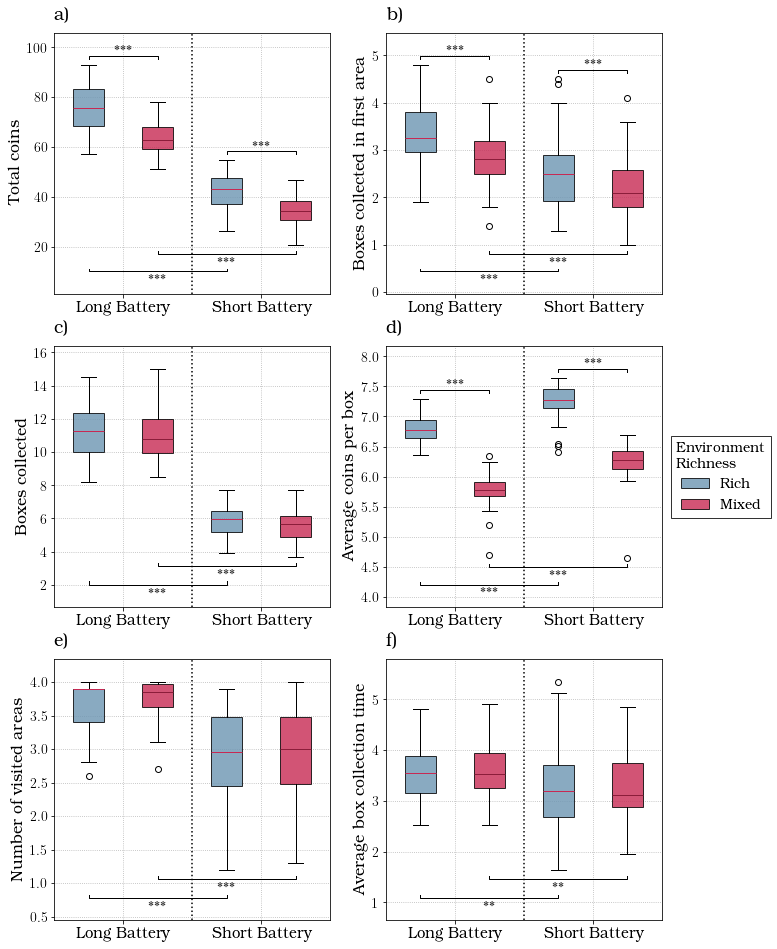

In [5]:
# Devo scrivere una funzione che mi estragga, per una variabile dipendente, una serie di liste a specifici valori dei fattori

color_rich = color_blue_pastel
color_poor = color_bordeaux

fig = plt.figure(figsize=(12,16), dpi=72)
# gs = fig.add_gridspec(3,3, width_ratios=(0.45,0.45,0.1), wspace=0.25)
gs = fig.add_gridspec(3,3, width_ratios=(0.45,0.45,0.01), wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

axes = [ax1, ax2, ax3, ax4, ax5, ax6]


box_colors = [color_rich, color_poor]
median_colors = [color_bordeaux, color_bordeaux * 0.7]
xlabels = ['Long Battery','Short Battery']
legend_labels = ['Rich','Mixed']

for i,var in enumerate([*variables,'TempiTraCasse']):

    ylabel = variables_pretty_names[var]
    ax = axes[i]

    boxplot_2x2(ax, results_df, var, condition_battery_env, significand_pairs_battey_env[var], box_colors, median_colors, xlabels, ylabel, legend_labels)

legend_gs = gs[0:3,2].subgridspec(3, 1, wspace=0, hspace=0)
ax_leg = fig.add_subplot(legend_gs[1,0])
plt.sca(ax_leg)
# plt.plot(np.random.rand(15))

ax_leg.spines.top.set_visible(False)
ax_leg.spines.bottom.set_visible(False)
ax_leg.spines.left.set_visible(False)
ax_leg.spines.right.set_visible(False)
ax_leg.set(xticks=[], yticks=[])

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = legend_labels[0])
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = legend_labels[1])
# plt.legend(handles = [patch_1, patch_2], loc='center', fontsize=14, fancybox=False, edgecolor='w')
plt.legend(handles = [patch_1, patch_2], loc='center', fontsize=14, fancybox=False, edgecolor='k', title='Environment\nRichness')

for i,l in enumerate(['a','b','c','d','e','f']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=18, weight='bold')

plt.savefig('Boxplot_Battery_Environment_Vertical.pdf', bbox_inches='tight', format='pdf')


In [1]:
# Devo scrivere una funzione che mi estragga, per una variabile dipendente, una serie di liste a specifici valori dei fattori

color_rich = color_blue_pastel
color_poor = color_bordeaux

fig = plt.figure(figsize=(20,12), dpi=72)
gs = fig.add_gridspec(2,4, width_ratios=(0.3,0.3,0.3,0.1), wspace=0.25)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

axes = [ax1, ax2, ax3, ax4, ax5, ax6]


box_colors = [color_rich, color_poor]
median_colors = [color_bordeaux, color_bordeaux * 0.7]
xlabels = ['Long Battery','Short Battery']
legend_labels = ['Rich\nEnvironment','Mixed\nEnvironment']

for i,var in enumerate([*variables,'TempiTraCasse']):

    ylabel = variables_pretty_names[var]
    ax = axes[i]

    print(significand_pairs_battey_env[var])

    boxplot_2x2(ax, results_df, var, condition_battery_env, significand_pairs_battey_env[var], box_colors, median_colors, xlabels, ylabel, legend_labels)

legend_gs = gs[0:2,3].subgridspec(3, 1, wspace=0, hspace=0)
ax_leg = fig.add_subplot(legend_gs[1,0])
plt.sca(ax_leg)
# plt.plot(np.random.rand(15))

ax_leg.spines.top.set_visible(False)
ax_leg.spines.bottom.set_visible(False)
ax_leg.spines.left.set_visible(False)
ax_leg.spines.right.set_visible(False)
ax_leg.set(xticks=[], yticks=[])

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = legend_labels[0])
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = legend_labels[1])
plt.legend(handles = [patch_1, patch_2], loc='center', fontsize=14, fancybox=False, edgecolor='w')

for i,l in enumerate(['a','b','c','d','e','f']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=18, weight='bold')

plt.savefig('Boxplot_Battery_Environment.pdf', bbox_inches='tight', format='pdf')


NameError: name 'color_blue_pastel' is not defined

# Analisi Battery x First Area Rich

### LMM

In [8]:
# Ciclo sulle variabili e per ognuna di essere faccio il linear mixed model
base = importr('base')
emmeans = importr('emmeans')
lme4 = importr('lme4')

results_df_only_poor = results_df[results_df['RichEnvironment'] == False]
robjects.globalenv['data'] = pandas2ri.py2rpy(results_df_only_poor)

lmm_battery_firstarea = {}
contrasts_battery_firstarea = {}
significant_pairs_battery_firstarea = {}

for var in [*variables, *variables_time]:

    print(f"\n\n INIZIO ANALISI VARIABILE {var}\n\n")
          
    model = Lmer(f"{var} ~ LongBattery * FirstAreaRich + (1|Subject)", data=results_df_only_poor)
    result_model = model.fit()
    random_effects = model.ranef.to_numpy()
    random_effects_variance = model.ranef_var['Var']['Subject']

    lmm_battery_firstarea[var] = {'Fixed': result_model, 'Random': model.ranef_var}

    # Ora faccio le comparison a due a due
    r_model = lme4.lmer(f"{var} ~ LongBattery * FirstAreaRich + (1|Subject)", data=robjects.globalenv['data'])
    emmeans_results = emmeans.emmeans(r_model, Formula('~ LongBattery * FirstAreaRich'))
    pairwise_contrasts = emmeans.contrast(emmeans_results, method='pairwise', simple='each', combine=True, adjust='tukey')

    pairwise_summary = base.summary(pairwise_contrasts)
    contrasts_battery_firstarea[var] = pairwise_summary

    # Trasformo i contrasti in linee di significatività
    df_contrast = robjects.conversion.rpy2py(pairwise_summary)
    inds_order = [(1,3),(0,2),(2,3),(0,1)]

    significant_pairs = []
    for i in range(4):
        p = df_contrast.iloc[i]['p.value']
        if p < 0.05:
            significant_pairs.append((inds_order[i][0], inds_order[i][1], p))

    significant_pairs_battery_firstarea[var] = significant_pairs




 INIZIO ANALISI VARIABILE CoinsGainedPerTrial




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: CoinsGainedPerTrial~LongBattery*FirstAreaRich+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 680	 Groups: {'Subject': 34.0}

Log-likelihood: -2371.469 	 AIC: 4754.937

Random effects:

                 Name     Var    Std
Subject   (Intercept)  31.390  5.603
Residual               56.029  7.485

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE BoxOpenedFirstArea




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: BoxOpenedFirstArea~LongBattery*FirstAreaRich+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 680	 Groups: {'Subject': 34.0}

Log-likelihood: -930.435 	 AIC: 1872.870

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.283  0.532
Residual               0.805  0.897

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE BoxOpenedPerTrial




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: BoxOpenedPerTrial~LongBattery*FirstAreaRich+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 680	 Groups: {'Subject': 34.0}

Log-likelihood: -1250.353 	 AIC: 2512.705

Random effects:

                 Name    Var    Std
Subject   (Intercept)  1.195  1.093
Residual               2.027  1.424

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE CoinGainedPerBoxPerTrialMean




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: CoinGainedPerBoxPerTrialMean~LongBattery*FirstAreaRich+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 680	 Groups: {'Subject': 34.0}

Log-likelihood: -494.921 	 AIC: 1001.842

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.051  0.226
Residual               0.226  0.475

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE VisitedAreasEnteredOnce




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: VisitedAreasEnteredOnce~LongBattery*FirstAreaRich+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 680	 Groups: {'Subject': 34.0}

Log-likelihood: -633.571 	 AIC: 1279.141

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.159  0.399
Residual               0.330  0.574

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE TempiTraCasse




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: TempiTraCasse~LongBattery*FirstAreaRich+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 680	 Groups: {'Subject': 34.0}

Log-likelihood: -984.573 	 AIC: 1981.147

Random effects:

                 Name   Var    Std
Subject   (Intercept)  0.29  0.539
Residual               0.95  0.975

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE TempiUltimaPrimaNuovaArea


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: TempiUltimaPrimaNuovaArea~LongBattery*FirstAreaRich+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 680	 Groups: {'Subject': 34.0}

Log-likelihood: -1308

c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [9]:
for v in [*variables,'TempiTraCasse']:
    print(v)
    display(lmm_battery_firstarea[v]['Fixed'])
    display(lmm_battery_firstarea[v]['Random'])

# display(robjects.conversion.rpy2py(contrasts_battey_env['CoinsGainedPerTrial'])['p.value'])


CoinsGainedPerTrial


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),33.732,31.533,35.931,1.122,51.506,30.063,0.000,***
LongBatteryTRUE,29.008,27.370,30.646,0.836,643.870,34.716,0.000,***
FirstAreaRichTRUE,1.931,0.320,3.542,0.822,645.831,2.349,0.019,*
LongBatteryTRUE:FirstAreaRichTRUE,-1.345,-3.616,0.926,1.159,644.636,-1.161,0.246,


,Name,Var,Std
Subject,(Intercept),31.390251,5.60270
Residual,,56.028668,7.48523


BoxOpenedFirstArea


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.632,1.408,1.857,0.115,62.504,14.241,0.000,***
LongBatteryTRUE,0.290,0.093,0.486,0.100,644.315,2.893,0.004,**
FirstAreaRichTRUE,1.205,1.012,1.398,0.098,647.253,12.239,0.000,***
LongBatteryTRUE:FirstAreaRichTRUE,0.479,0.207,0.751,0.139,645.469,3.451,0.001,***


,Name,Var,Std
Subject,(Intercept),0.282733,0.531726
Residual,,0.804860,0.897140


BoxOpenedPerTrial


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),5.606,5.180,6.032,0.217,50.586,25.779,0.000,***
LongBatteryTRUE,5.404,5.092,5.715,0.159,643.831,33.997,0.000,***
FirstAreaRichTRUE,-0.047,-0.354,0.259,0.156,645.705,-0.301,0.763,
LongBatteryTRUE:FirstAreaRichTRUE,0.056,-0.376,0.488,0.220,644.562,0.255,0.799,


,Name,Var,Std
Subject,(Intercept),1.194866,1.093099
Residual,,2.027239,1.423812


CoinGainedPerBoxPerTrialMean


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),6.002,5.898,6.107,0.053,78.420,112.410,0.0,***
LongBatteryTRUE,-0.263,-0.367,-0.159,0.053,644.900,-4.953,0.0,***
FirstAreaRichTRUE,0.455,0.353,0.557,0.052,649.094,8.724,0.0,***
LongBatteryTRUE:FirstAreaRichTRUE,-0.385,-0.530,-0.241,0.074,646.562,-5.242,0.0,***


,Name,Var,Std
Subject,(Intercept),0.050966,0.225756
Residual,,0.225995,0.475390


VisitedAreasEnteredOnce


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.129,2.969,3.289,0.082,54.499,38.353,0.000,***
LongBatteryTRUE,0.718,0.592,0.844,0.064,643.988,11.199,0.000,***
FirstAreaRichTRUE,-0.326,-0.450,-0.202,0.063,646.228,-5.171,0.000,***
LongBatteryTRUE:FirstAreaRichTRUE,0.111,-0.064,0.285,0.089,644.865,1.245,0.214,


,Name,Var,Std
Subject,(Intercept),0.159081,0.398850
Residual,,0.329830,0.574309


TempiTraCasse


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.223,2.989,3.456,0.119,66.896,27.023,0.000,***
LongBatteryTRUE,0.291,0.078,0.505,0.109,644.489,2.679,0.008,**
FirstAreaRichTRUE,0.202,-0.008,0.412,0.107,647.788,1.889,0.059,.
LongBatteryTRUE:FirstAreaRichTRUE,-0.068,-0.364,0.228,0.151,645.789,-0.452,0.652,


,Name,Var,Std
Subject,(Intercept),0.290098,0.538607
Residual,,0.950306,0.974837


[(1, 3, 0.0), (0, 2, 0.0)]
[(1, 3, 0.015668041868345695), (0, 2, 1.5987211554602254e-14), (2, 3, 0.0), (0, 1, 0.0)]
[(1, 3, 0.0), (0, 2, 0.0)]
[(1, 3, 3.735338691246426e-06), (0, 2, 0.0), (2, 3, 0.0)]
[(1, 3, 0.0), (0, 2, 0.0), (2, 3, 1.2423958806184743e-06), (0, 1, 0.0028043966083765026)]
[(1, 3, 0.029942984274533346)]


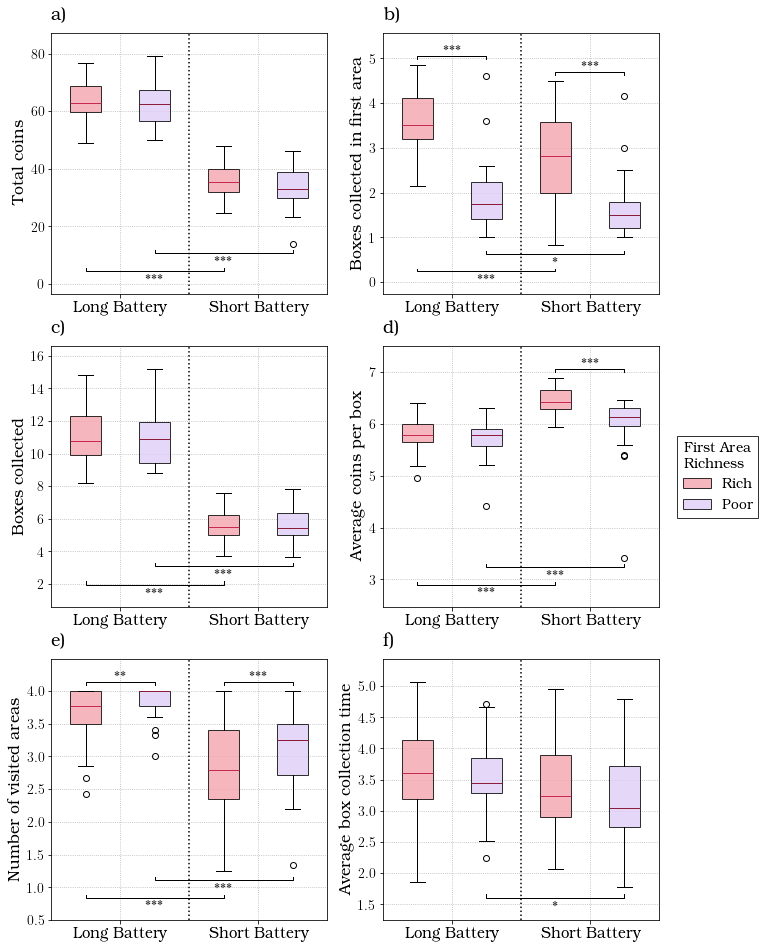

In [10]:
color_rich = color_pink_cherry
color_poor = color_violet

fig = plt.figure(figsize=(12,16), dpi=72)
gs = fig.add_gridspec(3,3, width_ratios=(0.45,0.45,0.01), wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

axes = [ax1, ax2, ax3, ax4, ax5, ax6]


box_colors = [color_rich, color_poor]
median_colors = [color_bordeaux, color_bordeaux * 0.7]
xlabels = ['Long Battery','Short Battery']
legend_labels = ['Rich','Poor']

for i,var in enumerate([*variables,'TempiTraCasse']):

    ylabel = variables_pretty_names[var]
    ax = axes[i]

    boxplot_2x2(ax, results_df, var, condition_battery_firstarea, significant_pairs_battery_firstarea[var], box_colors, median_colors, xlabels, ylabel, legend_labels)

legend_gs = gs[0:3,2].subgridspec(3, 1, wspace=0, hspace=0)
ax_leg = fig.add_subplot(legend_gs[1,0])
plt.sca(ax_leg)
# plt.plot(np.random.rand(15))

ax_leg.spines.top.set_visible(False)
ax_leg.spines.bottom.set_visible(False)
ax_leg.spines.left.set_visible(False)
ax_leg.spines.right.set_visible(False)
ax_leg.set(xticks=[], yticks=[])

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = legend_labels[0])
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = legend_labels[1])
plt.legend(handles = [patch_1, patch_2], loc='center', fontsize=14, fancybox=False, edgecolor='k', title='First Area\nRichness')

for i,l in enumerate(['a','b','c','d','e','f']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=18, weight='bold')

plt.savefig('Boxplot_Battery_FirstArea_Vertical.pdf', bbox_inches='tight', format='pdf')


# Analisi first area rich

### LMM

In [19]:
# Ciclo sulle variabili e per ognuna di essere faccio il linear mixed model
base = importr('base')
emmeans = importr('emmeans')
lme4 = importr('lme4')

results_df_only_firstrich = results_df[results_df['FirstAreaRich'] == True]
robjects.globalenv['data'] = pandas2ri.py2rpy(results_df_only_firstrich)

lmm_battery_firstarea = {}
contrasts_battery_firstarea = {}
significant_pairs_battery_firstarea = {}

for var in [*variables, *variables_time]:

    print(f"\n\n INIZIO ANALISI VARIABILE {var}\n\n")
          
    model = Lmer(f"{var} ~ LongBattery * RichEnvironment + (1|Subject)", data=results_df_only_firstrich)
    result_model = model.fit()
    random_effects = model.ranef.to_numpy()
    random_effects_variance = model.ranef_var['Var']['Subject']

    lmm_battery_firstarea[var] = {'Fixed': result_model, 'Random': model.ranef_var}

    # Ora faccio le comparison a due a due
    r_model = lme4.lmer(f"{var} ~ LongBattery * RichEnvironment + (1|Subject)", data=robjects.globalenv['data'])
    emmeans_results = emmeans.emmeans(r_model, Formula('~ LongBattery * RichEnvironment'))
    pairwise_contrasts = emmeans.contrast(emmeans_results, method='pairwise', simple='each', combine=True, adjust='tukey')

    pairwise_summary = base.summary(pairwise_contrasts)
    contrasts_battery_firstarea[var] = pairwise_summary

    # Trasformo i contrasti in linee di significatività
    df_contrast = robjects.conversion.rpy2py(pairwise_summary)
    inds_order = [(1,3),(0,2),(2,3),(0,1)]

    significant_pairs = []
    for i in range(4):
        p = df_contrast.iloc[i]['p.value']
        if p < 0.05:
            significant_pairs.append((inds_order[i][0], inds_order[i][1], p))

    significant_pairs_battery_firstarea[var] = significant_pairs




 INIZIO ANALISI VARIABILE CoinsGainedPerTrial




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: CoinsGainedPerTrial~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1035	 Groups: {'Subject': 34.0}

Log-likelihood: -3789.209 	 AIC: 7590.418

Random effects:

                 Name     Var    Std
Subject   (Intercept)  44.278  6.654
Residual               81.425  9.024

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE BoxOpenedFirstArea




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: BoxOpenedFirstArea~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1035	 Groups: {'Subject': 34.0}

Log-likelihood: -1427.439 	 AIC: 2866.879

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.420  0.648
Residual               0.836  0.914

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE BoxOpenedPerTrial




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: BoxOpenedPerTrial~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1035	 Groups: {'Subject': 34.0}

Log-likelihood: -1927.337 	 AIC: 3866.673

Random effects:

                 Name    Var    Std
Subject   (Intercept)  1.273  1.128
Residual               2.194  1.481

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE CoinGainedPerBoxPerTrialMean




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: CoinGainedPerBoxPerTrialMean~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1035	 Groups: {'Subject': 34.0}

Log-likelihood: -444.683 	 AIC: 901.367

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.038  0.195
Residual               0.126  0.355

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE VisitedAreasEnteredOnce




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: VisitedAreasEnteredOnce~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1035	 Groups: {'Subject': 34.0}

Log-likelihood: -977.714 	 AIC: 1967.428

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.209  0.457
Residual               0.347  0.589

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE TempiTraCasse




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: TempiTraCasse~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1035	 Groups: {'Subject': 34.0}

Log-likelihood: -1454.684 	 AIC: 2921.369

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.349  0.591
Residual               0.888  0.942

No random effect correlations specified

Fixed effects:



 INIZIO ANALISI VARIABILE TempiUltimaPrimaNuovaArea




c:\Users\ISTC-CNR\miniconda3\Lib\site-packages\pymer4\models\Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Linear mixed model fit by REML [’lmerMod’]
Formula: TempiUltimaPrimaNuovaArea~LongBattery*RichEnvironment+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 1035	 Groups: {'Subject': 34.0}

Log-likelihood: -2053.483 	 AIC: 4118.966

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.396  0.629
Residual               3.454  1.859

No random effect correlations specified

Fixed effects:



In [20]:
for v in [*variables,'TempiTraCasse']:
    print(v)
    display(lmm_battery_firstarea[v]['Fixed'])
    display(lmm_battery_firstarea[v]['Random'])

CoinsGainedPerTrial


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),35.704,33.087,38.321,1.335,54.753,26.743,0.0,***
LongBatteryTRUE,27.719,25.838,29.599,0.959,998.551,28.890,0.0,***
RichEnvironmentTRUE,6.240,4.578,7.903,0.848,998.664,7.356,0.0,***
LongBatteryTRUE:RichEnvironmentTRUE,6.209,3.890,8.528,1.183,998.363,5.247,0.0,***


,Name,Var,Std
Subject,(Intercept),44.278487,6.654208
Residual,,81.424577,9.023557


BoxOpenedFirstArea


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2.842,2.585,3.100,0.131,56.846,21.621,0.000,***
LongBatteryTRUE,0.766,0.576,0.957,0.097,998.714,7.884,0.000,***
RichEnvironmentTRUE,-0.286,-0.455,-0.118,0.086,998.836,-3.331,0.001,***
LongBatteryTRUE:RichEnvironmentTRUE,0.038,-0.197,0.273,0.120,998.513,0.315,0.753,


,Name,Var,Std
Subject,(Intercept),0.419962,0.648045
Residual,,0.835723,0.914179


BoxOpenedPerTrial


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),5.561,5.121,6.000,0.224,53.326,24.774,0.000,***
LongBatteryTRUE,5.470,5.162,5.779,0.158,998.518,34.730,0.000,***
RichEnvironmentTRUE,0.266,-0.007,0.539,0.139,998.625,1.909,0.056,.
LongBatteryTRUE:RichEnvironmentTRUE,-0.060,-0.441,0.320,0.194,998.341,-0.310,0.756,


,Name,Var,Std
Subject,(Intercept),1.272863,1.128212
Residual,,2.194485,1.481379


CoinGainedPerBoxPerTrialMean


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),6.459,6.375,6.544,0.043,73.878,149.723,0.0,***
LongBatteryTRUE,-0.651,-0.725,-0.577,0.038,999.087,-17.244,0.0,***
RichEnvironmentTRUE,0.770,0.705,0.836,0.033,999.280,23.084,0.0,***
LongBatteryTRUE:RichEnvironmentTRUE,0.199,0.108,0.291,0.047,998.767,4.284,0.0,***


,Name,Var,Std
Subject,(Intercept),0.038012,0.194967
Residual,,0.126084,0.355083


VisitedAreasEnteredOnce


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),2.803,2.626,2.981,0.091,52.607,30.958,0.000,***
LongBatteryTRUE,0.832,0.709,0.954,0.063,998.538,13.271,0.000,***
RichEnvironmentTRUE,0.111,0.003,0.220,0.055,998.642,2.009,0.045,*
LongBatteryTRUE:RichEnvironmentTRUE,-0.081,-0.233,0.070,0.077,998.368,-1.050,0.294,


,Name,Var,Std
Subject,(Intercept),0.209148,0.457327
Residual,,0.347385,0.589394


TempiTraCasse


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.420,3.176,3.664,0.125,63.747,27.465,0.000,***
LongBatteryTRUE,0.226,0.029,0.422,0.100,998.826,2.253,0.024,*
RichEnvironmentTRUE,-0.118,-0.291,0.056,0.089,998.978,-1.330,0.184,
LongBatteryTRUE:RichEnvironmentTRUE,0.024,-0.218,0.266,0.124,998.574,0.194,0.847,


,Name,Var,Std
Subject,(Intercept),0.349362,0.591069
Residual,,0.887513,0.942079


In [35]:
print(variables)

['CoinsGainedPerTrial', 'BoxOpenedFirstArea', 'BoxOpenedPerTrial', 'CoinGainedPerBoxPerTrialMean', 'VisitedAreasEnteredOnce']


[(1, 3, 0.0), (0, 2, 0.0), (2, 3, 1.5774048733874224e-12), (0, 1, 0.0)]
[(1, 3, 3.3306690738754696e-14), (0, 2, 0.0), (2, 3, 0.003578291182158466), (0, 1, 0.012224886067458418)]
[(1, 3, 0.0), (0, 2, 0.0)]
[(1, 3, 0.0), (0, 2, 0.0), (2, 3, 0.0), (0, 1, 0.0)]
[(1, 3, 0.0), (0, 2, 0.0)]
[(0, 2, 0.002321347022108955)]
[(1, 3, 3.3306690738754696e-14), (0, 2, 0.0), (2, 3, 0.003578291182158466), (0, 1, 0.012224886067458418)]


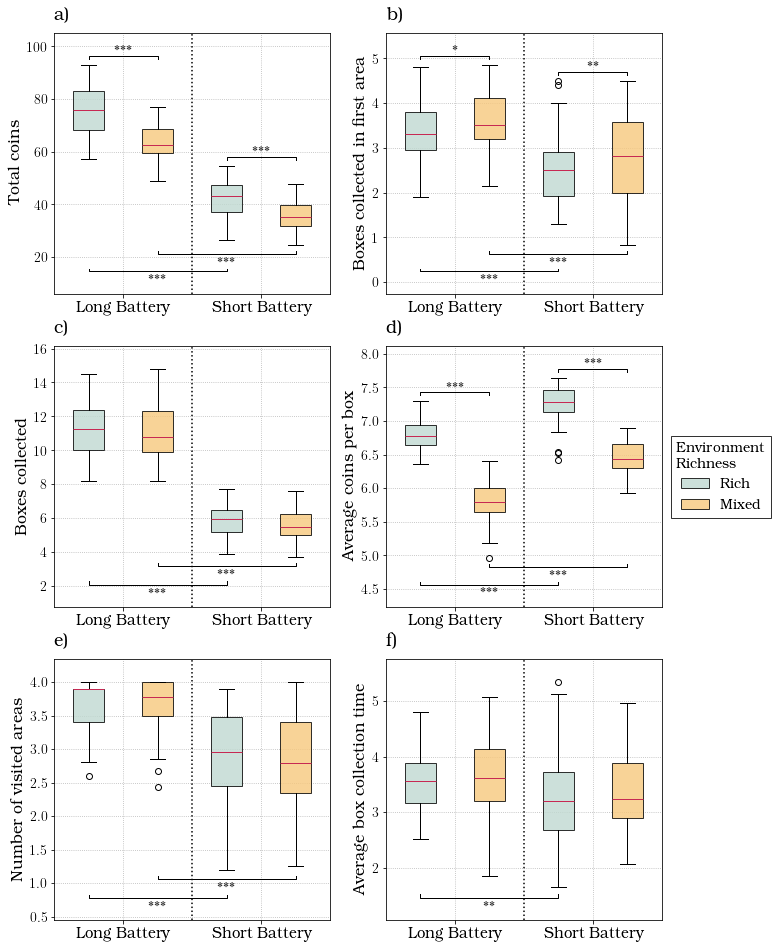

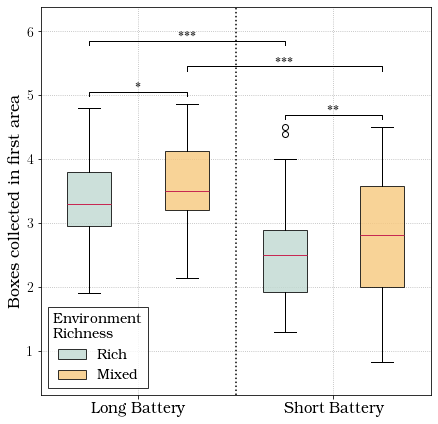

In [41]:
color_rich = color_blue_pastel
color_poor = color_bordeaux
color_rich_optimal = color_rich * 0.6 + np.ones(3) * 0.4 + 0.1 * np.array([1,1,0])
color_poor_optimal = color_poor * 0.6 + np.ones(3) * 0.2 + 0.3 * np.array([0.5,1,0])
color_poor_optimal = color_yellow_sunset

box_colors = [color_rich, color_rich_optimal, color_poor, color_poor_optimal] * 2



fig = plt.figure(figsize=(12,16), dpi=72)
gs = fig.add_gridspec(3,3, width_ratios=(0.45,0.45,0.01), wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

axes = [ax1, ax2, ax3, ax4, ax5, ax6]


box_colors = [color_rich_optimal, color_poor_optimal] * 2


# box_colors = [color_rich, color_poor]
median_colors = [color_bordeaux, color_bordeaux] * 2
xlabels = ['Long Battery','Short Battery']
legend_labels = ['Rich','Mixed']

for i,var in enumerate([*variables,'TempiTraCasse']):

    ylabel = variables_pretty_names[var]
    ax = axes[i]

    boxplot_2x2(ax, results_df, var, condition_battery_firstarea_rich, significant_pairs_battery_firstarea[var], box_colors, median_colors, xlabels, ylabel, legend_labels)

legend_gs = gs[0:3,2].subgridspec(3, 1, wspace=0, hspace=0)
ax_leg = fig.add_subplot(legend_gs[1,0])
plt.sca(ax_leg)
# plt.plot(np.random.rand(15))

ax_leg.spines.top.set_visible(False)
ax_leg.spines.bottom.set_visible(False)
ax_leg.spines.left.set_visible(False)
ax_leg.spines.right.set_visible(False)
ax_leg.set(xticks=[], yticks=[])

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = legend_labels[0])
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = legend_labels[1])
plt.legend(handles = [patch_1, patch_2], loc='center', fontsize=14, fancybox=False, edgecolor='k', title='Environment\nRichness')

for i,l in enumerate(['a','b','c','d','e','f']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=18, weight='bold')

plt.savefig('Boxplot_Battery_FirstAreaRich.pdf', bbox_inches='tight', format='pdf')



## Solo pannello B
fig = plt.figure(figsize=(7,7), dpi=72)
ax = plt.gca()
var = 'BoxOpenedFirstArea'
ylabel = variables_pretty_names[var]
boxplot_2x2(ax, results_df, var, condition_battery_firstarea_rich, significant_pairs_battery_firstarea[var], box_colors, median_colors, xlabels, ylabel, legend_labels, only_top_lines=True)

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = legend_labels[0])
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = legend_labels[1])
plt.legend(handles = [patch_1, patch_2], loc='lower left', fontsize=14, fancybox=False, edgecolor='k', title='Environment\nRichness')


plt.savefig('Boxplot_Battery_FirstAreaRich_OnlyBoxesFirstArea.pdf', bbox_inches='tight', format='pdf')


# Learning

0.5877977119197679
8.023310768292155e-09
0.28739071980237063
0.000363369340239817
0.5523227088388887
3.9629402857357994e-08
0.0661586146459379
0.10909733224993926
0.6949262873654
2.4392946087327736e-11
0.6730322101655855
9.239249681822648e-11


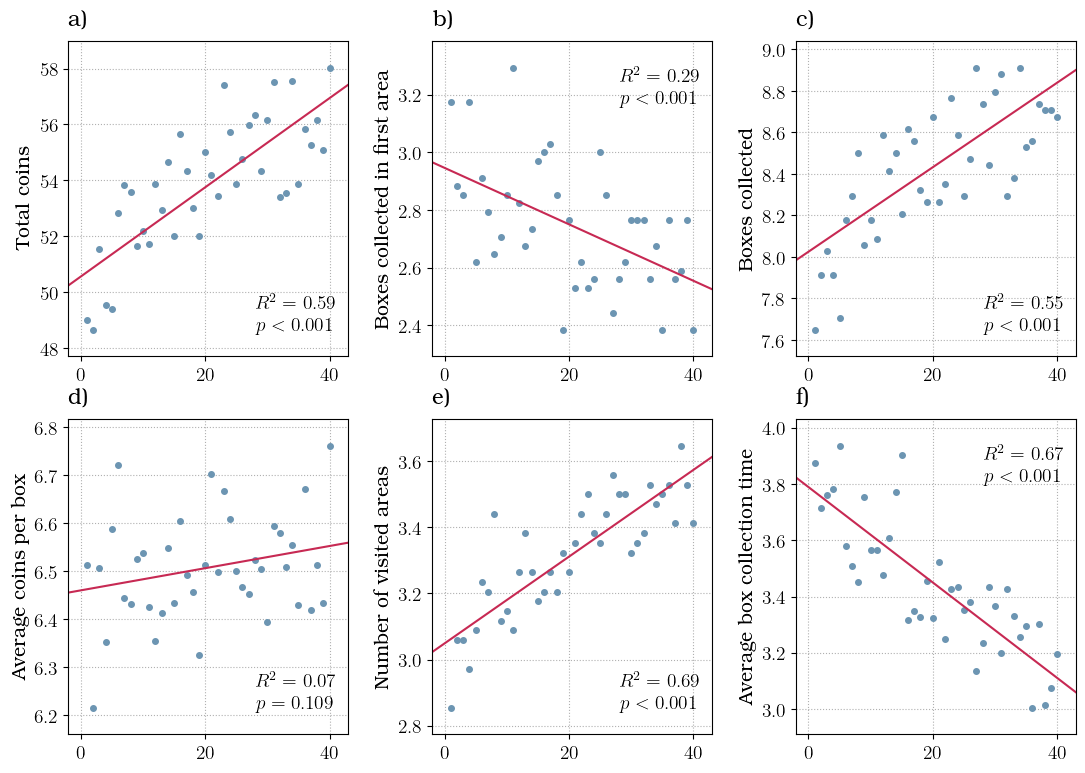

In [11]:
# Plot apprendimento
from scipy.stats import linregress

from utils import linear_plot_errors

results_per_trial = results_df.groupby('Trial').mean()
results_per_trial_std = results_df.groupby('Trial').std()


fig = plt.figure(figsize=(13,9))
gs = fig.add_gridspec(2,3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[1, 2])

axes = [ax1, ax2, ax3, ax4, ax5, ax6]


for i, var in enumerate([*variables,'TempiTraCasse']):

    plt.sca(axes[i])

    x = np.arange(1,41)
    y = results_per_trial[var]
    y_std = results_per_trial_std[var]
    r, p = linear_plot_errors(x,y,y_std=y_std,show_errorbars=False,area_alpha=0, col=color_blue_pastel, linecol=color_bordeaux)

    yrange = np.max(y) - np.min(y)
    plt.ylabel(variables_pretty_names[var])
    plt.xlim([-2,43])
    plt.ylim([np.min(y) - 0.1 * yrange, np.max(y) + 0.1 * yrange])
    plt.grid(True,linestyle=':')
    print(p)

    if p > 0.001: p_text = f'$p = {p:.3f}$'
    else: p_text = '$p < 0.001$'

    if i == 1 or i == 5:
        plt.annotate(f'$R^2 = {r**2:.2f}$\n{p_text}',(28, np.max(y)), va='top')
    else:
        plt.annotate(f'$R^2 = {r**2:.2f}$\n{p_text}',(28, np.min(y)))


for i,l in enumerate(['a','b','c','d','e','f']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=16, weight='bold')


plt.savefig('Learning.pdf', bbox_inches='tight', format='pdf')
    


Ora analizzo come cambiano i risultati tra la prima e seconda metà, separando i gruppi di persone che hanno fatto prima i trial lunghi e poi i corti e viceversa. Provo a farlo senza mediare sui trial per risolvere i problemi con le significatività, ma lo faccio anche mediando

[(2, 3, 0.01915410427784617)]
[(2, 3, 0.013084858375292708)]
[(0, 1, 0.04903481079239323)]
[(2, 3, 0.025167006892858914)]


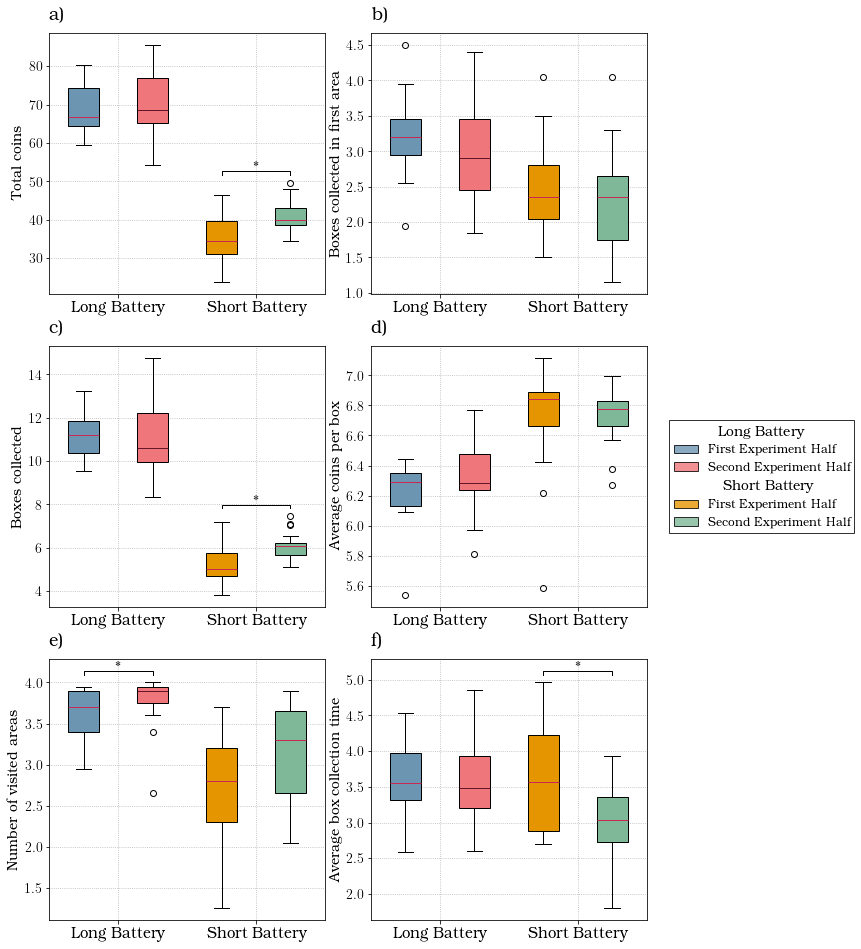

In [12]:
# Persone che hanno fatto prima i long battery e poi gli short, da confrontare con quelli che hanno fatto prima gli short. Come faccio a fare sto confronto?
# Inizio separando i casi: long before + long battery, long before + short battery, ecc..
# Mediando su tutte le altre condizioni

fig = plt.figure(figsize=(14,16), dpi=72)
gs = fig.add_gridspec(3,3, width_ratios=(0.4,0.4,0.2), wspace=0.2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for i,var in enumerate([*variables,'TempiTraCasse']):
    # var = 'CoinsGainedPerTrial'

    plt.sca(axes[i])

    cond_before = [(True,True), (False,True), (True,False), (False,False)]
    x = []
    x_avg = []

    for c in cond_before:
        mask = (results_df['FirstHalf'] == c[0]) & (results_df['LongBattery'] == c[1])
        x.append(results_df[mask][var])
        x_avg.append(results_df[mask].groupby('Subject').mean()[var])
        

    test_comb = [(0,1),(2,3)]
    box_colors = [color_blue_pastel, color_light_coral, color_yellow, color_green_pastel]
    median_colors = [color_bordeaux, color_bordeaux*0.5, color_bordeaux, color_bordeaux] 

    boxplot(x_avg, test_combinations=test_comb, box_colors=box_colors, median_colors=median_colors)
    plt.xticks([1.5,3.5], ['Long Battery','Short Battery'], fontsize=15)
    plt.grid(True,linestyle=':')
    plt.ylabel(variables_pretty_names[var])



legend_gs = gs[0:3,2].subgridspec(3, 1, wspace=0, hspace=0)
ax_leg = fig.add_subplot(legend_gs[1,0])
plt.sca(ax_leg)
# plt.plot(np.random.rand(15))

ax_leg.spines.top.set_visible(False)
ax_leg.spines.bottom.set_visible(False)
ax_leg.spines.left.set_visible(False)
ax_leg.spines.right.set_visible(False)
ax_leg.set(xticks=[], yticks=[])

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = 'First Experiment Half')
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = 'Second Experiment Half')
patch_3 = patches.Patch(facecolor=box_colors[2], alpha=0.8, edgecolor='k',  label = 'First Experiment Half')
patch_4 = patches.Patch(facecolor=box_colors[3], alpha=0.8, edgecolor='k',  label = 'Second Experiment Half')
# plt.legend(handles = [patch_1, patch_2, patch_3, patch_4], fontsize=9, fancybox=False, edgecolor='k')
patch_sep = patches.Circle((0,0),0, facecolor='r', alpha=1, edgecolor='w',  label = 'Short Battery')

leg = plt.legend(handles = [patch_1, patch_2, patch_sep, patch_3, patch_4], ncols=1, loc='center', fontsize=12, fancybox=False, edgecolor='k', title='Long Battery')
plt.setp(leg.get_title(),fontsize=14)
leg.get_patches()[2].set_width(0)
leg.get_texts()[2].set_x(15)
plt.setp(leg.get_texts()[2], fontsize=14)

for i,l in enumerate(['a','b','c','d','e','f']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=18, weight='bold')


plt.savefig('Learning_FirstSecondHalf.pdf', bbox_inches='tight', format='pdf')


# Optimality

[ 2  3  5  8 10 12 13 15 20 21 22 26 28 29 30 31 33]
[(0, 1, 0.006985811348138173), (2, 3, 0.00035213937806400275)]
[(0, 1, 0.032936339086446144), (2, 3, 0.0009153639401995101), (4, 5, 0.00343320280963434)]
None
Text(-18, 0, 'Mixed Environment')


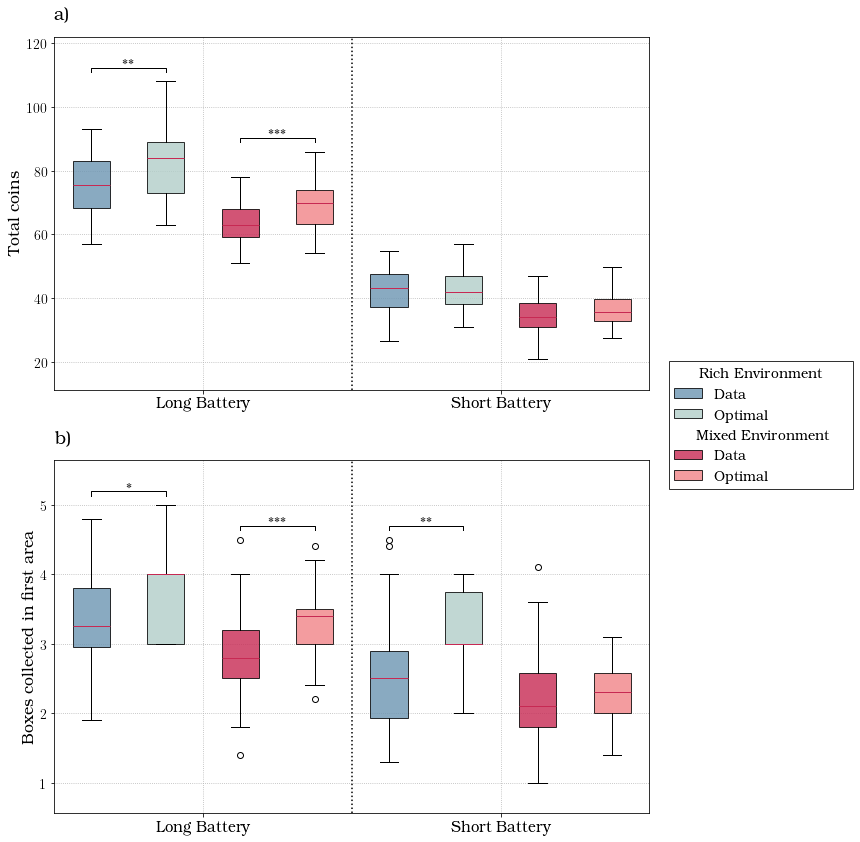

In [16]:
with open('ResultsFinal_NoOptimalitySplit.pkl','rb') as f:
    results_df_no_split = pkl.load(f)

color_rich_optimal = color_rich * 0.7 + np.ones(3) * 0.3 + 0.1 * np.array([1,1,0])
color_poor_optimal = color_poor * 0.7 + np.ones(3) * 0.3 + 0.1 * np.array([1,1,0])

box_colors = [color_rich, color_rich_optimal, color_poor, color_poor_optimal] * 2
median_colors = [color_bordeaux] * 8


fig = plt.figure(figsize=(14,14), dpi=72)
gs = fig.add_gridspec(2,2, width_ratios=[0.8,0.2], wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

axes = [ax1, ax2] 

subj_first_long = results_df_no_split[(results_df_no_split['FirstHalf'] == True) & (results_df_no_split['LongBattery'] == True) ]['Subject'].unique()
subj_first_short =  results_df_no_split[(results_df_no_split['FirstHalf'] == True) & (results_df_no_split['LongBattery'] == False) ]['Subject'].unique()
print(subj_first_long)
# Coins
for i,var in enumerate(['CoinsGainedPerTrial','BoxOpenedFirstArea']):

    x_data = get_data_for_condition(results_df_no_split, var, condition_battery_env)
    x_optimal =  get_data_for_condition(results_df_no_split, var + '_Optimal', condition_battery_env)
        
    x = [x_data[0], x_optimal[0], x_data[1], x_optimal[1], x_data[2], x_optimal[2], x_data[3], x_optimal[3]]
    test_combinations = [(0,1),(2,3),(4,5),(6,7)]

    plt.sca(axes[i])

    point_colors = np.zeros((34,3))
    point_colors[subj_first_long,:] = np.array([1,1,1])
    point_colors[subj_first_short,:] = np.array([1,0,0])
    point_colors = 'w'

    boxplot(x, test_combinations=test_combinations, boxes_alpha=0.8, box_colors=box_colors, median_colors=median_colors,
            show_connecting_lines=False, points_colors=point_colors,connecting_lines_skip=2)


    y_lim = plt.ylim()
    y_range = (y_lim[1] - y_lim[0])
    space = y_range * 0.05
    y_lim_new = [y_lim[0] - space, y_lim[1] + space]

    # Disegno la linea verticale come separatore e 
    plt.plot([4.5,4.5], y_lim_new,':k')
    plt.ylim(y_lim_new)
    plt.xticks([2.5,6.5], ['Long Battery','Short Battery'], fontsize=15)
    plt.ylabel(variables_pretty_names[var], fontsize=16)
    plt.grid(True, linestyle=':')


legend_gs = gs[0:2,1].subgridspec(3, 1, wspace=0, hspace=0)
ax_leg = fig.add_subplot(legend_gs[1,0])
plt.sca(ax_leg)
# plt.plot(np.random.rand(15))

ax_leg.spines.top.set_visible(False)
ax_leg.spines.bottom.set_visible(False)
ax_leg.spines.left.set_visible(False)
ax_leg.spines.right.set_visible(False)
ax_leg.set(xticks=[], yticks=[])

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = 'Data')
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = 'Optimal')
patch_sep = patches.Circle((0,0),0, facecolor='r', alpha=1, edgecolor='w',  label = 'Mixed Environment')
patch_sep.set_width(0)
patch_3 = patches.Patch(facecolor=box_colors[2], alpha=0.8, edgecolor='k', label = 'Data')
patch_4 = patches.Patch(facecolor=box_colors[3], alpha=0.8, edgecolor='k',  label = 'Optimal')
leg = plt.legend(handles = [patch_1, patch_2, patch_sep, patch_3, patch_4], ncols=1, loc='center', fontsize=14, fancybox=False, edgecolor='k', title='Rich Environment')
leg.get_patches()[2].set_width(0)
print(leg.get_texts()[2].set_x(-18))
print(leg.get_texts()[2])


for i,l in enumerate(['a','b']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=18, weight='bold')

plt.savefig('OptimalityNoTimeDivision_NoOptimalitySplit.pdf', bbox_inches='tight', format='pdf')

### Caso Environment Poor, analisi first area

[(0, 1, 0.0004337471708315308), (2, 3, 0.0006106607785007717)]
[(0, 1, 2.9307534861893523e-12), (2, 3, 0.004740068340065303), (4, 5, 7.512824173774873e-05), (6, 7, 4.496130614966278e-09)]
None
Text(-18, 0, 'First Area Poor')


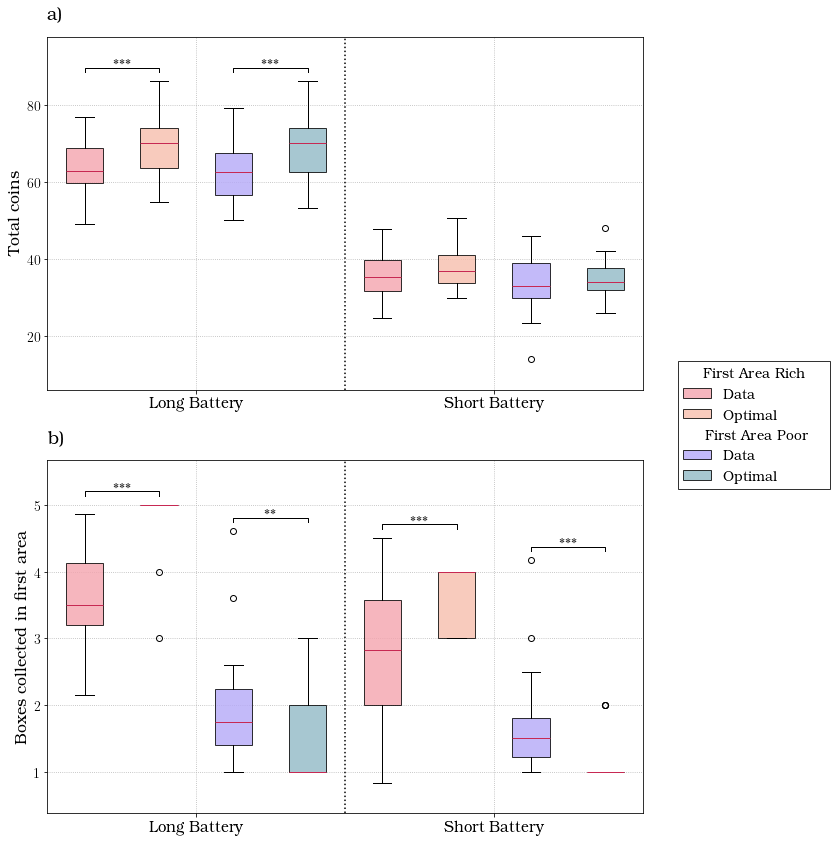

In [18]:
color_rich = color_pink_cherry
color_poor = color_violet * 0.7  + np.ones(3) * 0.1 + 0.2 * np.array([0,0,1])


color_rich_optimal = color_rich * 0.7 + np.ones(3) * 0.2 + 0.1 * np.array([1,1,0])
color_poor_optimal = color_poor * 0.8 + 0.2 * np.array([0,1,0])


box_colors = [color_rich, color_rich_optimal, color_poor, color_poor_optimal] * 2
median_colors = [color_bordeaux] * 8

fig = plt.figure(figsize=(14,14), dpi=72)
gs = fig.add_gridspec(2,2, width_ratios=[0.8,0.2], wspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

axes = [ax1, ax2] 

# Coins
for i,var in enumerate(['CoinsGainedPerTrial','BoxOpenedFirstArea']):

    x_data = get_data_for_condition(results_df_no_split, var, condition_battery_firstarea)
    x_optimal =  get_data_for_condition(results_df_no_split, var + '_Optimal', condition_battery_firstarea)
        
    x = [x_data[0], x_optimal[0], x_data[1], x_optimal[1], x_data[2], x_optimal[2], x_data[3], x_optimal[3]]
    test_combinations = [(0,1),(2,3),(4,5),(6,7)]

    plt.sca(axes[i])

    point_colors = 'w'

    boxplot(x, test_combinations=test_combinations, boxes_alpha=0.8, box_colors=box_colors, median_colors=median_colors,
            show_connecting_lines=False, points_colors=point_colors,connecting_lines_skip=2)


    y_lim = plt.ylim()
    y_range = (y_lim[1] - y_lim[0])
    space = y_range * 0.05
    y_lim_new = [y_lim[0] - space, y_lim[1] + space]

    # Disegno la linea verticale come separatore e 
    plt.plot([4.5,4.5], y_lim_new,':k')
    plt.ylim(y_lim_new)
    plt.xticks([2.5,6.5], ['Long Battery','Short Battery'], fontsize=15)
    plt.ylabel(variables_pretty_names[var], fontsize=16)
    plt.grid(True, linestyle=':')


legend_gs = gs[0:2,1].subgridspec(3, 1, wspace=0, hspace=0)
ax_leg = fig.add_subplot(legend_gs[1,0])
plt.sca(ax_leg)
# plt.plot(np.random.rand(15))

ax_leg.spines.top.set_visible(False)
ax_leg.spines.bottom.set_visible(False)
ax_leg.spines.left.set_visible(False)
ax_leg.spines.right.set_visible(False)
ax_leg.set(xticks=[], yticks=[])

patch_1 = patches.Patch(facecolor=box_colors[0], alpha=0.8, edgecolor='k', label = 'Data')
patch_2 = patches.Patch(facecolor=box_colors[1], alpha=0.8, edgecolor='k',  label = 'Optimal')
patch_sep = patches.Circle((0,0),0, facecolor='r', alpha=1, edgecolor='w',  label = 'First Area Poor')
patch_sep.set_width(0)
patch_3 = patches.Patch(facecolor=box_colors[2], alpha=0.8, edgecolor='k', label = 'Data')
patch_4 = patches.Patch(facecolor=box_colors[3], alpha=0.8, edgecolor='k',  label = 'Optimal')
leg = plt.legend(handles = [patch_1, patch_2, patch_sep, patch_3, patch_4], ncols=1, loc='center', fontsize=14, fancybox=False, edgecolor='k', title='First Area Rich')
leg.get_patches()[2].set_width(0)
print(leg.get_texts()[2].set_x(-18))
print(leg.get_texts()[2])


for i,l in enumerate(['a','b']):
    axes[i].text(0, 1.05, f'{l})', transform=axes[i].transAxes, size=18, weight='bold')

plt.savefig('OptimalityNoTimeDivision_NoOptimalitySplit_FirstArea.pdf', bbox_inches='tight', format='pdf')

# Spiegazione decision tree

Per spiegare il modello metterei un grafico che mostri come funzione il decision tree stocastico

c:\Users\ISTC-CNR\OneDrive - CNR\Desktop\Davide\OptimalForaging\ContoPython\utils.py:570: SyntaxWarning: invalid escape sequence '\%'
  plt.text(c_avg[0] + 0.1 + 0.1 * dx, c_avg[1], '$50\%$', ha='left', va='center', fontsize=11)


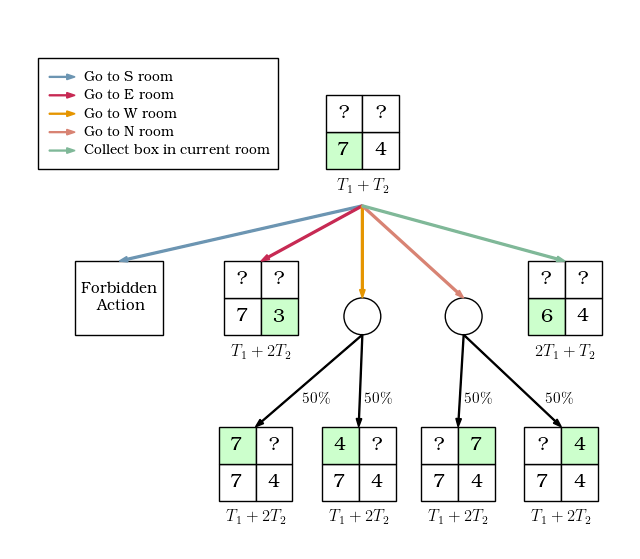

In [630]:
from utils import plot_decision_state, plot_decision_arrow, plot_decision_circle, plot_circle_arrow, plot_decision_impossible
plt.figure(figsize=(8,7))

dx = 5.5
ddx = 1.4
x_shift = -1.5
dy = 4.5
c1 = np.array([0,0])
c2 = np.array([-2*dx,-3])
c3 = np.array([-dx,-5])
c4 = np.array([0,-5])
c5 = np.array([dx,-5])
c6 = np.array([2*dx,-5])

c_states = [(-dx -ddx + x_shift,-2*dy), (-dx + ddx + x_shift,-2*dy), (0-ddx + x_shift,-2*dy), (0 + ddx + x_shift,-2*dy), (dx-ddx + x_shift,-2*dy), (dx + ddx + x_shift,-2*dy)]
c_circles = [(-dx/2 , -dy),(0, -dy-0.5),(dx/2 , -dy-0.5)]
c_state_deterministic = (dx, -dy)
c_impossible = (-dx * 1.2, -dy)
c7 = np.array([-1.5*dx,-8])

# Primo stato
plot_decision_state(['7','4','?','?'], 0, 'T_1 + T_2', np.zeros(2))

# Stati deterministici
plot_decision_state(['6','4','?','?'], 0, '2 T_1 + T_2', c_state_deterministic)
plot_decision_state(['7','3','?','?'], 1, 'T_1 + 2 T_2', c_circles[0])

# Altri stati che escono da risultati stocastici
# plot_decision_circle(c_circles[0])
plot_decision_circle(c_circles[1])
plot_decision_circle(c_circles[2])

# plot_decision_state(['7','7','?','?'], 1, '$T_2$', c_states[0])
# plot_decision_state(['7','4','?','?'], 1, '$T_2$', c_states[1])
plot_decision_state(['7','4','7','?'], 2, 'T_1 + 2 T_2', c_states[2])
plot_decision_state(['7','4','4','?'], 2, 'T_1 + 2 T_2', c_states[3])
plot_decision_state(['7','4','?','7'], 3, 'T_1 + 2 T_2', c_states[4])
plot_decision_state(['7','4','?','4'], 3, 'T_1 + 2 T_2', c_states[5])

# Decisione impossibile
plot_decision_impossible(c_impossible)

# # Frecce dal primo stato
plot_decision_arrow(np.zeros(2), c_impossible, color_blue_pastel)
plot_decision_arrow(np.zeros(2), c_circles[0], color_bordeaux)
plot_circle_arrow(np.zeros(2), c_circles[1],color_yellow)
plot_circle_arrow(np.zeros(2), c_circles[2],color_pink_coral)
plot_decision_arrow(np.zeros(2), c_state_deterministic, color_green_pastel)

plot_circle_arrow(c_circles[1], c_states[2],'k', from_circle=True, width=0.025)
plot_circle_arrow(c_circles[1], c_states[3],'k', from_circle=True, width=0.025)
plot_circle_arrow(c_circles[2], c_states[4],'k', from_circle=True, width=0.025)
plot_circle_arrow(c_circles[2], c_states[5],'k', from_circle=True, width=0.025)

# Legenda
legend_x = -8.5
legend_dx = 0.7
legend_dy = 0.5
legend_cols = [color_blue_pastel, color_bordeaux, color_yellow, color_pink_coral, color_green_pastel]
legend_texts = ['Go to S room','Go to E room','Go to W room','Go to N room','Collect box in current room']

patch = patches.Rectangle((legend_x - 0.3, 1.5 - legend_dy*5), 6.5, 3, fc='w', ec='k')
ax = plt.gca()
ax.add_patch(patch)

for i in [0,1,2,3,4]:
    plt.arrow(legend_x, 1.5-i * legend_dy, legend_dx, 0, width=0.025, color=legend_cols[i], length_includes_head=True, head_width=0.15)
    plt.text(legend_x + legend_dx + 0.25, 1.5-i*legend_dy, legend_texts[i], ha='left', va='center', fontsize=10)

plt.xlim([-10,10])
plt.ylim([-15,3])
plt.axis('equal')
plt.axis('off')

plt.savefig('DecisionTreeDiagram.pdf', bbox_inches='tight', format='pdf')



### Ottimalità numero di coin al variare del trial

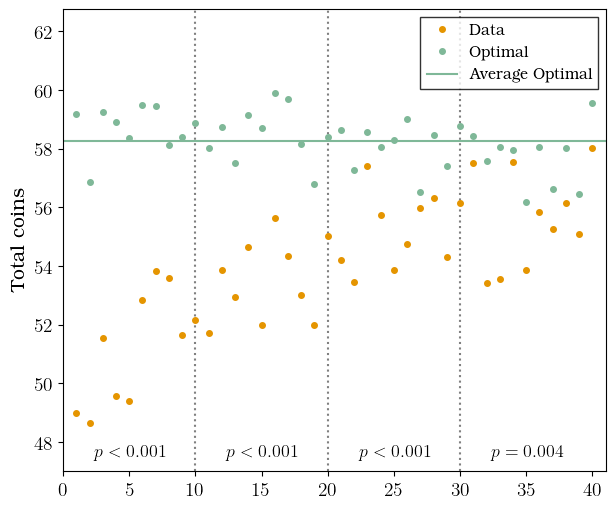

In [298]:
from scipy.signal import savgol_filter
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

results_per_trial = results_df_no_split.groupby('Trial').mean()
results_per_trial_std = results_df_no_split.groupby('Trial').std()


fig = plt.figure(figsize=(7,6))

var = 'CoinsGainedPerTrial'

x = np.arange(1,41)

ylim = [47,62.75]

for i in range(3):
    plt.plot([10 + i *10]*2, ylim,':', color=[0.5,0.5,0.5])

# Risultati data
y = results_per_trial[var]
y_smooth =  lowess(y, x)
y_opt = results_per_trial[var + '_Optimal']
y_opt_std = results_per_trial_std[var + '_Optimal']

plt.plot(x,y,'.', markersize=8, color=color_yellow, label='Data')
plt.plot(x,y_opt,'.', markersize=8, color=color_green_pastel, label='Optimal')
plt.plot(plt.xlim(),[np.mean(y_opt),np.mean(y_opt)],'-', color=color_green_pastel, label='Average Optimal')


yrange = np.max(y) - np.min(y)
plt.ylabel(variables_pretty_names[var])
plt.xlim([0,41])
plt.ylim(ylim)
# plt.grid(True,linestyle=':')

if p > 0.001: p_text = f'$p = {p:.3f}$'
else: p_text = '$p < 0.001$'

plt.legend(fontsize=11, fancybox=False, edgecolor='k', loc='upper right')

for i in range(4):
    pos_x = i * 10 + 5
    pos_y = 47.5
    if i == 3:
        text = '$p = 0.004$'
    else:
        text = '$p < 0.001$'
    plt.text(pos_x, pos_y, text, fontsize=13, weight='bold', ha='center')

plt.savefig('TotalCoins_Optimality_ByTrial.pdf', bbox_inches='tight', format='pdf')